In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



## Motivation



Our dataset is the Enron Email Dataset, a collection of approximately 500,000 internal emails from around 150 Enron employees—primarily executives—spanning the years 1998 to 2002. It was released by the Federal Energy Regulatory Commission (FERC) during investigations into Enron’s collapse and later curated by the CALO Project at Carnegie Mellon University.


We chose the Enron Email Dataset because it provides a rare and rich source of real-world corporate communication data that is both large-scale and publicly available. The Enron scandal is one of the most infamous cases of corporate fraud in U.S. history, involving large-scale accounting manipulation, insider trading, and ethical misconduct. This context makes the dataset highly relevant for studying patterns of communication that might signal unethical or fraudulent behavior. Moreover, it has been widely used in previous research on social network analysis and NLP, giving us a solid foundation for our work while allowing room for novel approaches.


Our goal was to explore whether natural language processing (NLP) techniques can be used to identify suspicious behavior, key individuals, or hidden communication patterns within an organization. For the end user—such as auditors, compliance officers, or investigators—we envision a tool that can enhance traditional fraud detection methods by flagging anomalous communication behavior or surfacing important actors in a corporate network. Ultimately, our aim is to contribute to tools that make large-scale communication data more interpretable and actionable in preventing or detecting fraud.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import networkx as nx
import nxviz as nv


/Users/christianwarburg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/christianwarburg/anaconda3/lib/python3.11/site-packages/nxviz/__init__.py:33: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## The Dataset and Data Cleaning

The Enron email corpus initially comprises over 500,000 messages exchanged among more than 5,000 unique addresses, but raw data at this scale contains a great deal of noise and automated traffic that can obscure meaningful social interactions. To produce a high‐quality network for analysis, we applied several successive filters:

1. **Remove incomplete records.** Any email lacking a valid sender, recipient, subject line, or message body was discarded. This eliminated messages that were malformed, empty, or otherwise unsuitable for content-based or network analysis.

2. **Filter out system-generated and broadcast lists.** Addresses associated with payroll, distribution lists (e.g., `all.employees`), public relations, announcement channels, “team.\*” groups, and similar automated sources were identified via keyword matching (e.g., `payroll`, `list`, `distribution`, `announcement`, `team.`) and excluded. By doing so, we focused exclusively on one-to-one or small-group human correspondence.

3. **Drop self-sent emails.** Messages where the sender and primary recipient were identical—essentially personal notes filed in one’s own inbox—were removed, since they do not represent true interpersonal communication.

4. **Constrain to truly People of Interest.** Since there are so many emails from different employees, we constrained the emails to only people on the exucutive level. Each email has a `user` label, so we decided to only keep emails that were either sent or recieved from a `user`. This lead to 150 people, only on the exucutive level.

After these preprocessing steps, the dataset shrank from roughly **517,000** raw emails to **16,000** emails exchanged among **150** active employees. This distilled network captures the most substantial, person-to-person interactions, laying a solid foundation for centrality, community detection, and other graph-theoretic analyses.


In [3]:
pd.options.mode.chained_assignment = None

data = pd.read_csv('../emails_structured.csv')


data.info()
len(data)

#Can we print the first row in the data? Im specifically intersed in the user

#print all users

users = data['user'].unique()


print(f'Number of emails: {len(data)}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Message-ID  517401 non-null  object
 1   Date        517401 non-null  object
 2   From        517401 non-null  object
 3   To          495554 non-null  object
 4   Subject     498214 non-null  object
 5   X-From      517372 non-null  object
 6   X-To        508248 non-null  object
 7   X-cc        128886 non-null  object
 8   X-bcc       175 non-null     object
 9   X-Folder    517372 non-null  object
 10  X-Origin    517372 non-null  object
 11  X-FileName  513229 non-null  object
 12  content     517401 non-null  object
 13  user        517401 non-null  object
dtypes: object(14)
memory usage: 55.3+ MB
Number of emails: 517401


In [4]:
#Here you can see an example of a funny email. There are some redundant rows, so we will clean it to make it more readable

print(data.iloc[70000])
print('\nExample of a message\n')
print(data.iloc[70000]['content'])


Message-ID        <18132723.1075851652519.JavaMail.evans@thyme>
Date                                  2001-10-03 22:01:52+00:00
From                                           ['bkc7@pge.com']
To                                       ['jdasovic@enron.com']
Subject                                                     NaN
X-From                             Cherry, Brian <BKC7@pge.com>
X-To                Dasovich Jeff (E-mail) <jdasovic@enron.com>
X-cc                                                        NaN
X-bcc                                                       NaN
X-Folder      \Dasovich, Jeff (Non-Privileged)\Dasovich, Jef...
X-Origin                                             DASOVICH-J
X-FileName                  Dasovich, Jeff (Non-Privileged).pst
content       Well, I wonder what Davis will do now ?  Veto ...
user                                                 dasovich-j
Name: 70000, dtype: object

Example of a message

Well, I wonder what Davis will do now ?  Veto AB2X 18 

In [5]:
#Now we want to clean it!
#We decide to keep the following columns: Message-ID, X-From, X-To, Date, content and user. The user is either the sender or the receiver of the email.

df_clean = data[['Message-ID','X-From','X-To','Date','content','user']].rename(columns={
    'Message-ID': 'message_id',
    'X-From': 'sender',
    'X-To': 'receiver',
    'Date': 'date',
    'X-Origin': 'origin'
})

df_clean['sender'] = df_clean['sender'].str.replace(r'<.*?>', '', regex=True).str.strip()
df_clean['receiver'] = df_clean['receiver'].str.replace(r'<.*?>', '', regex=True).str.strip()

# Convert 'date' column to datetime dtype
df_clean['date'] = pd.to_datetime(df_clean['date'])
#After
df_clean.iloc[70000]

message_id        <18132723.1075851652519.JavaMail.evans@thyme>
sender                                            Cherry, Brian
receiver                                 Dasovich Jeff (E-mail)
date                                  2001-10-03 22:01:52+00:00
content       Well, I wonder what Davis will do now ?  Veto ...
user                                                 dasovich-j
Name: 70000, dtype: object

In [6]:
#Delete all emails, that does not have a sender or receiver or text or subject
df_len = len(df_clean)
df_clean = df_clean.dropna(subset=['sender', 'receiver', 'content','message_id','user'])

print(f'Deleted {df_len - len(df_clean)} rows with missing values')

users = df_clean['user'].unique()
users = list(users)


Deleted 9153 rows with missing values


In [7]:
#Since we dont know if the sender is the same as the user, we will create a new column with the sender code.
# To determine wheater the email is sent or recived from the user, we will create a new column with the sender code. This ensures
# that we can identify the sender and receiver of the email. We will also create a new column with the receiver code.
def name_to_code(name: str) -> str:
    """Convert a display name into 'last-firstInitial' code, or None if not parsable."""
    clean = re.sub(r'\(.*?\)', '', name).strip()
    # Try "Last, First" format
    if ',' in clean:
        parts = [x.strip() for x in clean.split(',', 1)]
        if len(parts) == 2 and parts[0] and parts[1]:
            last, first = parts
        else:
            return None
    else:
        # Try "First Last" or "Last First"
        parts = clean.split()
        if len(parts) == 2:
            first, last = parts
        else:
            return None
    if not first or not last:
        return None
    return f"{last.lower()}-{first[0].lower()}"

# Apply conversion safely
df_clean['sender_code'] = df_clean['sender'].apply(name_to_code)
df_clean['receiver_code'] = df_clean['receiver'].apply(name_to_code)

# Filter where either code is in your valid_names list
filtered_df = df_clean[
    df_clean['sender_code'].isin(users) &
    df_clean['receiver_code'].isin(users)
].reset_index(drop=True)




### Save the final dataset as a .csv file

In [8]:
#We remove emails where the sender and receiver are the same, because these will probably just be notes to self

filtered_df = filtered_df[filtered_df['sender_code'] != filtered_df['receiver_code']].reset_index(drop=True)
#save the filtered dataframe to a csv file
filtered_df.to_csv('../filtered_emails.csv', index=False)


## Network analysis.

 In the following part of the code, we will calculate different network metrics including centrality scores, betweenness scores, community detection aswell as basic network metrics such as degree

In [ ]:
#Visualize the data
import networkx as nx
import plotly.graph_objs as go

# Build directed graph G
G = nx.DiGraph()
for _, row in filtered_df.iterrows():
    s, r, u = row['sender_code'], row['receiver_code'], row['user']
    if s == u:
        G.add_edge(u, r)
    elif r == u:
        G.add_edge(s, u)

# Compute layout
pos = nx.spring_layout(G, k=0.5)

# Create edge traces
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=0.5),
    hoverinfo='none'
)

# Create node traces
node_x, node_y, labels = [], [], []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    labels.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=labels,
    textposition='top center',
    marker=dict(size=10),
    hoverinfo='text'
)

# Build figure
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title_text="Email Communication Network",
    showlegend=False,
    margin=dict(b=0, l=0, r=0, t=30)
)

# Save to HTML
fig.write_html("email_network_plotly.html", include_plotlyjs='cdn')

# Display link for download
print("Interactive network saved to email_network_plotly.html")


Interactive network saved to email_network_plotly.html


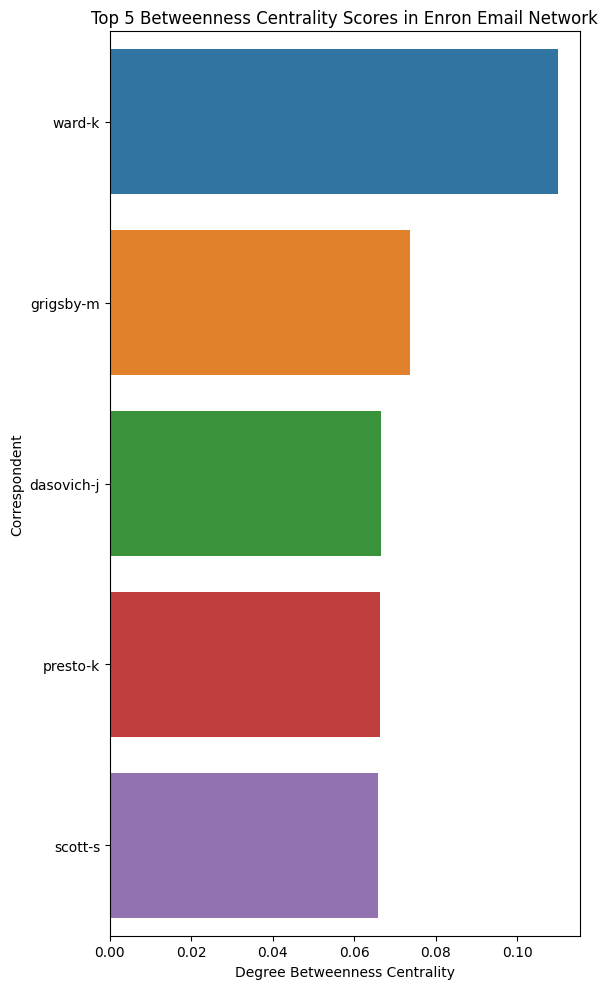

In [20]:
between = nx.betweenness_centrality(G)
name = []
betweenness = []

for key, value in between.items():
    name.append(key)
    betweenness.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['betweenness'] = betweenness
bet = bet.sort_values(by='betweenness', ascending=False)


plt.figure(figsize=(6, 10))
_ = sns.barplot(x='betweenness', y='name', data=bet[:5], orient='h')
_ = plt.xlabel('Degree Betweenness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 5 Betweenness Centrality Scores in Enron Email Network')
plt.tight_layout()  # adjust subplot params to give margins for labels
plt.savefig('images/betweenness.png', bbox_inches='tight')
plt.show()

In [ ]:
#community detection

# Use Louvain method for community detection
communities = nx.community.louvain_communities(G)

# Print number of communities found
print(f"Number of communities detected: {len(communities)}")

# Create a mapping of node to community number
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Add community information to nodes
nx.set_node_attributes(G, community_map, 'community')

# Print size of each community
print("\nCommunity sizes:")
for i, community in enumerate(communities):
    print(f"Community {i}: {len(community)} nodes")

# Visualize top 5 largest communities
community_sizes = [len(c) for c in communities]
top_5_indices = sorted(range(len(community_sizes)), key=lambda k: community_sizes[k], reverse=True)[:5]

plt.figure(figsize=(10, 25))
for idx in top_5_indices:
    community = communities[idx]
    subgraph = G.subgraph(community)
    print(f"\nTop 5 central nodes in community {idx}:")
    # Get degree centrality for nodes in this community
    deg_cent = nx.degree_centrality(subgraph)
    top_nodes = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    for node, centrality in top_nodes:
        print(f"{node}: {centrality:.3f}")


Number of communities detected: 6

Community sizes:
Community 0: 28 nodes
Community 1: 18 nodes
Community 2: 30 nodes
Community 3: 17 nodes
Community 4: 25 nodes
Community 5: 22 nodes

Top 5 central nodes in community 2:
lavorato-j: 1.172
kitchen-l: 1.069
whalley-g: 0.897
kean-s: 0.897
beck-s: 0.793

Top 5 central nodes in community 0:
grigsby-m: 1.407
lenhart-m: 0.852
keiser-k: 0.704
smith-m: 0.704
allen-p: 0.630

Top 5 central nodes in community 4:
symes-k: 0.667
semperger-c: 0.667
solberg-g: 0.542
salisbury-h: 0.500
forney-j: 0.458

Top 5 central nodes in community 5:
nemec-g: 1.333
perlingiere-d: 1.190
williams-j: 1.095
ward-k: 1.095
taylor-m: 0.905

Top 5 central nodes in community 1:
arnold-j: 1.059
neal-s: 1.000
griffith-j: 1.000
brawner-s: 0.824
mckay-j: 0.706
Kenneth Lay is in community 2
Members of Kenneth Lay's community:
['delainey-d', 'steffes-j', 'sturm-f', 'shapiro-r', 'sanders-r', 'kitchen-l', 'cash-m', 'shankman-j', 'skilling-j', 'quenet-j', 'rogers-b', 'lay-k', 'benso

<Figure size 1000x2500 with 0 Axes>

Average degree of the network: 18.93
Most connected node: lavorato-j with degree 61
Lavorato-j is in community 2
Members of Lavorato-j's community:
['delainey-d', 'steffes-j', 'sturm-f', 'shapiro-r', 'sanders-r', 'kitchen-l', 'cash-m', 'shankman-j', 'skilling-j', 'quenet-j', 'rogers-b', 'lay-k', 'benson-r', 'lavorato-j', 'zipper-a', 'davis-d', 'buy-r', 'dasovich-j', 'arora-h', 'zufferli-j', 'kaminski-v', 'whalley-g', 'beck-s', 'donohoe-t', 'white-s', 'presto-k', 'kean-s', 'ring-r', 'haedicke-m', 'swerzbin-m']


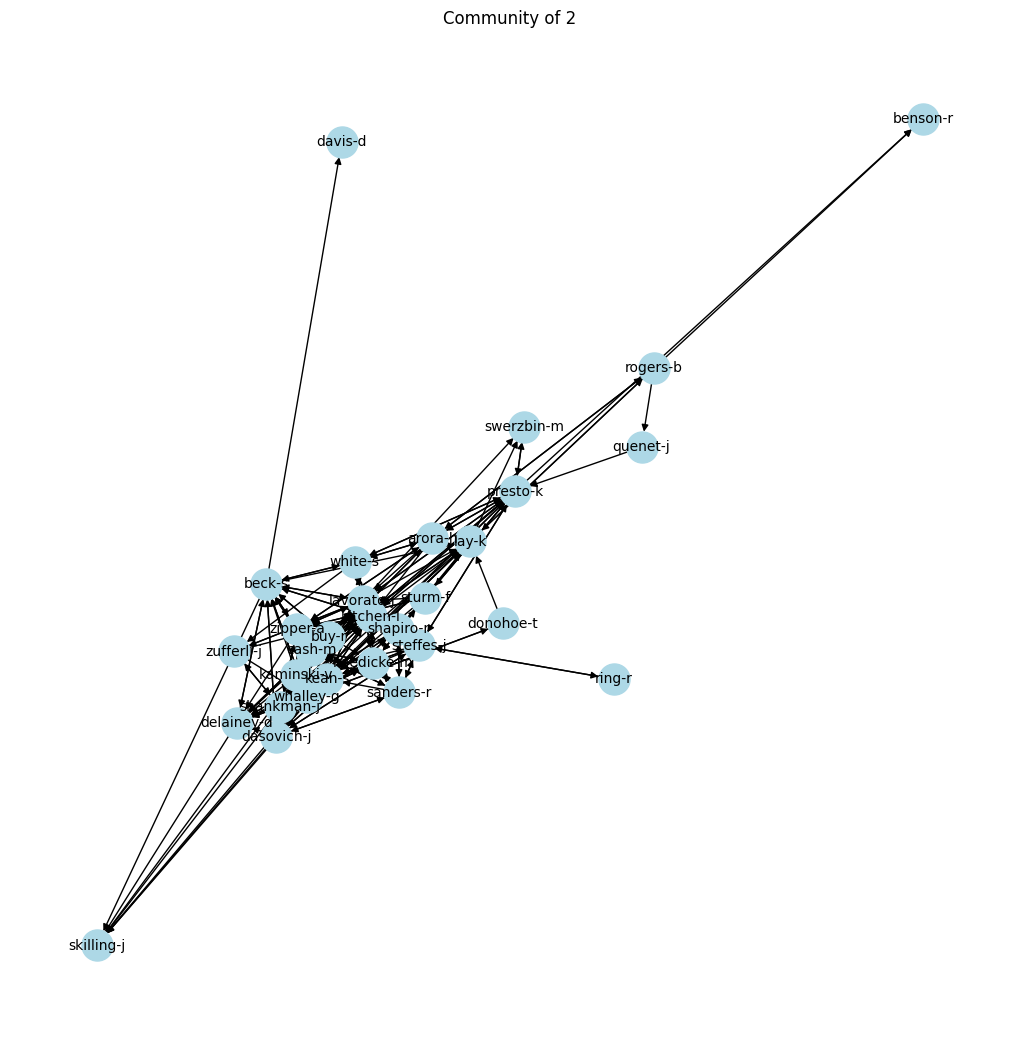

In [25]:
#find average degree of the network
degree = dict(G.degree())
degree_values = list(degree.values())
avg_degree = sum(degree_values) / len(degree_values)
print(f"Average degree of the network: {avg_degree:.2f}")
#find the most connected node
max_degree_node = max(degree, key=degree.get)
max_degree = degree[max_degree_node]
print(f"Most connected node: {max_degree_node} with degree {max_degree}")
#who is in lavorato-j community
lavorato_j_community = community_map.get('lavorato-j')
print(f"Lavorato-j is in community {lavorato_j_community}")
#members of the community
print(f"Members of Lavorato-j's community:")
members = [node for node, comm in community_map.items() if comm == lavorato_j_community]
print(members)

#make a graph of the community
subgraph = G.subgraph(members)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10)
plt.title(f"Community of {lavorato_j_community}")
plt.savefig('images/community_lavorato.png', bbox_inches='tight')
plt.show()


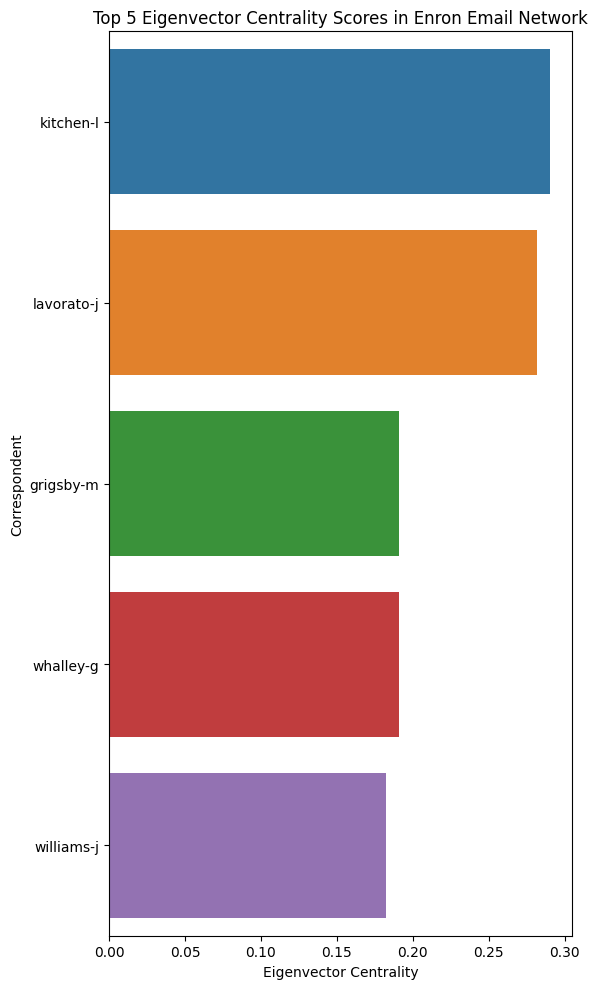

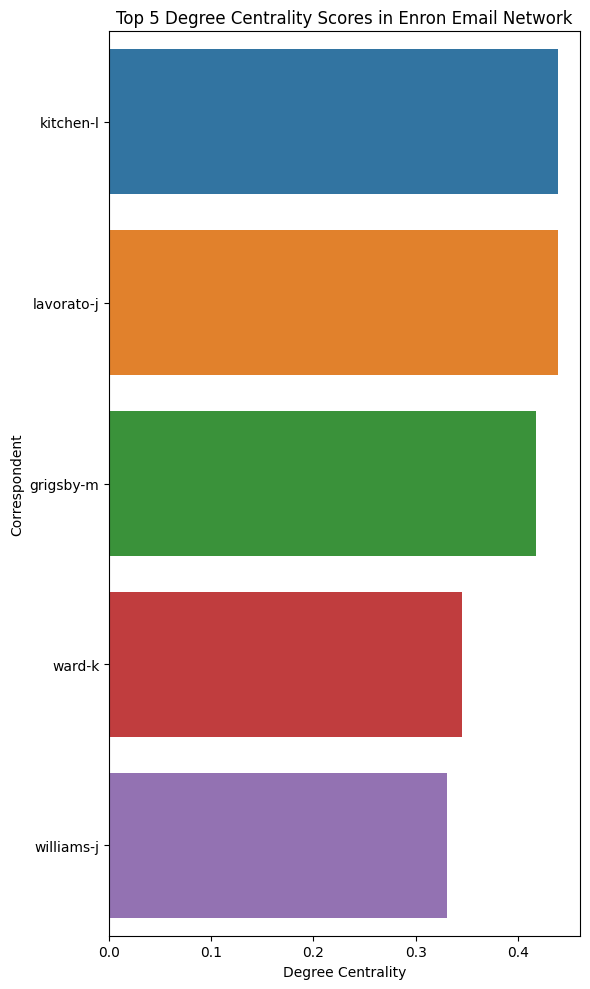

In [26]:
eigencent = nx.eigenvector_centrality(G)
name = []
eigencentrality = []
for key, value in eigencent.items():
    name.append(key)
    eigencentrality.append(value)
eig = pd.DataFrame()
eig['name'] = name
eig['eigencentrality'] = eigencentrality
eig = eig.sort_values(by='eigencentrality', ascending=False)
plt.figure(figsize=(6, 10))
_ = sns.barplot(x='eigencentrality', y='name', data=eig[:5], orient='h')
_ = plt.xlabel('Eigenvector Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 5 Eigenvector Centrality Scores in Enron Email Network')
plt.tight_layout()  # adjust subplot params to give margins for labels
plt.savefig('images/eigencentrality.png', bbox_inches='tight')

plt.show()

#centrality
#degree centrality
degree = nx.degree_centrality(G)
name = []
degreecentrality = []
for key, value in degree.items():
    name.append(key)
    degreecentrality.append(value)
deg = pd.DataFrame()
deg['name'] = name
deg['degreecentrality'] = degreecentrality
deg = deg.sort_values(by='degreecentrality', ascending=False)
plt.figure(figsize=(6, 10))
_ = sns.barplot(x='degreecentrality', y='name', data=deg[:5], orient='h')
_ = plt.xlabel('Degree Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 5 Degree Centrality Scores in Enron Email Network')
plt.tight_layout()  # adjust subplot params to give margins for labels
plt.savefig('images/degreecentrality.png', bbox_inches='tight')
plt.show()